## Classification of active municipalities

In [24]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import ydata_profiling
from ydata_profiling import ProfileReport
import seaborn as sns
import numpy as np

In [15]:
df = pd.read_csv("../data/interim/twitter_weather_electrical.csv")
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df).set_crs('EPSG:4326')
df['hour_blocks'] = df['time'].str.split(':').str[0].astype(int)

In [16]:
df = df.drop(['user', 'language', 'geometry_y'], axis=1)

Calculate hour categories

In [17]:
def categorize_hour(hour):
    if 2 <= hour < 8:
        return 'A'  # 2-7
    elif 8 <= hour < 14:
        return 'B'  # 8-13
    elif 14 <= hour < 20:
        return 'C'  # 14-19
    elif (20 <= hour <= 23) or (0 <= hour <= 1):  # 20-23 or 00-01
        return 'D'
    else:
        return None  # Fallback in case something doesn't match

# Apply the function to create the hour_category
df['hour_category'] = df['hour_blocks'].apply(categorize_hour)

In [18]:
df

date   time  timestamp_x      municipality.name  hour_blocks  \
0      2013-11-01  00:04   1383260656                 Trento            0   
1      2013-11-01  00:01   1383260474                Pinzolo            0   
2      2013-11-01  00:43   1383262983               Cavalese            0   
3      2013-11-01  00:38   1383262717               Rovereto            0   
4      2013-11-01  00:45   1383263140  San Michele all'Adige            0   
...           ...    ...          ...                    ...          ...   
27931  2013-12-31  00:25   1388445948          Vigo di Fassa            0   
27932  2013-12-29  13:12   1388319166               Predazzo           13   
27933  2013-11-19  00:51   1384818699      Sant'Orsola Terme            0   
27934  2013-11-23  09:49   1385196576      Sant'Orsola Terme            9   
27935  2013-12-31  16:31   1388503893       Palù del Fersina           16   

                        geometry station  elevation  timestamp_y  \
0      POINT (11.13000 46.07000)   T0129        312   1383260400   
1      POINT (10.83000 46.23000)   T0071        905   1383260400   
2      POINT (11.46000 46.29000)   T0367        958   1383260400   
3      POINT (11.04000 45.89000)   T0147        203   1383260400   
4      POINT (11.12000 46.20000)   T0408        204   1383260400   
...                          ...     ...        ...          ...   
27931  POINT (11.68000 46.42000)   T0096       1205   1388444400   
27932  POINT (11.60000 46.31000)   T0389       1000   1388271600   
27933  POINT (11.30000 46.11000)   T0139        925   1384815600   
27934  POINT (11.30000 46.11000)   T0139        925   1385161200   
27935  POINT (11.35000 46.13000)   T0139        925   1388444400   

       minTemperature  ...  precipitation  minWind  maxWind  temperature  \
0                11.7  ...            0.0      0.2      2.0         13.2   
1                 4.5  ...            0.0      0.0      2.5          8.4   
2                 7.0  ...            0.0      0.0      1.8          8.8   
3                11.0  ...            0.0      0.2      1.9         13.2   
4                 9.6  ...            0.0      NaN      NaN         11.6   
...               ...  ...            ...      ...      ...          ...   
27931           -10.0  ...            0.0      NaN      NaN         -7.8   
27932             0.4  ...            0.0      NaN      NaN          3.4   
27933             4.3  ...            0.0      NaN      NaN          4.8   
27934            -1.6  ...            0.0      NaN      NaN          0.8   
27935            -4.0  ...            0.0      NaN      NaN         -0.3   

          wind cellId  tot_curr_cell  NR_SITES  curr_site  hour_category  
0         1@47   5201      90.971940    1288.0   0.070630              D  
1      0.1@205   7167       1.784586      24.0   0.074358              D  
2          NaN   8151       0.000000       0.0   0.000000              D  
3        0.6@7   2855      47.591226     995.0   0.047830              D  
4          NaN   6838       0.100372       4.0   0.025093              D  
...        ...    ...            ...       ...        ...            ...  
27931      NaN   9922       0.000000       0.0   0.000000              D  
27932      NaN   8513       0.000000       0.0   0.000000              B  
27933      NaN   5799       0.000000       0.0   0.000000              D  
27934      NaN   5799       0.000000       0.0   0.000000              B  
27935      NaN   6037       0.030289       2.0   0.015145              C  

[27936 rows x 21 columns]

In [350]:
df['wind_speed'] = df['wind'].str.split('@').str[0].astype(float)

In [360]:
df['wind_dir'] = df['wind'].str.split('@').str[1].astype(float)

In [362]:
df['wind_dir'].isna().sum()

11233

In [394]:
df_grouped = df.groupby(['date', 'municipality.name', 'hour_category']).agg({
    'temperature':'mean',
    'minTemperature':'mean',
    'maxTemperature':'mean',
    'precipitation':'mean',
    'wind_speed':'mean',
    'wind_dir':'mean',
    'tot_curr_cell':'mean',
    'curr_site':'mean',
    'timestamp_x': 'count' 
}).rename(columns={'timestamp_x': 'tweet_count', 'tot_curr_cell': 'curr_cell'}).reset_index()

In [395]:
df_grouped

date municipality.name hour_category  temperature  minTemperature  \
0     2013-11-01            Andalo             A     9.200000             8.5   
1     2013-11-01   Baselga di Pinè             B    11.533333             8.0   
2     2013-11-01   Baselga di Pinè             C    11.433333             7.3   
3     2013-11-01   Baselga di Pinè             D     9.350000             6.6   
4     2013-11-01           Bedollo             B    14.120000             8.7   
...          ...               ...           ...          ...             ...   
5026  2013-12-31     Vigo di Fassa             B    -7.450000           -10.0   
5027  2013-12-31     Vigo di Fassa             C    -3.966667           -10.0   
5028  2013-12-31     Vigo di Fassa             D    -8.125000           -10.0   
5029  2013-12-31      Villa Agnedo             C     0.533333            -3.3   
5030  2013-12-31   Ziano di Fiemme             C    -2.100000            -5.7   

      maxTemperature  precipitation  wind_speed  wind_dir  curr_cell  \
0          12.000000            0.0         NaN       NaN   0.000000   
1          13.733333            0.0         0.2     236.0   5.996413   
2          12.966667            0.0         0.0     184.0  10.637787   
3          12.200000            0.0         NaN       NaN  18.809585   
4          14.500000            0.0         0.3     232.5   0.383955   
...              ...            ...         ...       ...        ...   
5026        0.300000            0.0         NaN       NaN   0.000000   
5027        0.300000            0.0         NaN       NaN   0.000000   
5028        0.300000            0.0         NaN       NaN   0.000000   
5029        4.900000            0.0         NaN       NaN   9.225448   
5030        2.200000            0.0         NaN       NaN   0.659693   

      curr_site  tweet_count  
0      0.000000            1  
1      0.016458            3  
2      0.017426            3  
3      0.024556            2  
4      0.015358            5  
...         ...          ...  
5026   0.000000            4  
5027   0.000000            3  
5028   0.000000            4  
5029   0.044170            3  
5030   0.047121            1  

[5031 rows x 12 columns]

In [423]:
top = 4
middle = 46
bottom = 50

In [424]:
conditions = [
    (df_grouped['tweet_count'] >= df_grouped['tweet_count'].quantile(1-top/100)),  
    (df_grouped['tweet_count'] < df_grouped['tweet_count'].quantile(1-top/100)) & 
    (df_grouped['tweet_count'] >= df_grouped['tweet_count'].quantile(1-bottom/100)),  
    (df_grouped['tweet_count'] < df_grouped['tweet_count'].quantile(1-bottom/100))    
]

In [425]:
choices = ['High', 'Medium', 'Low']
df_grouped['class'] = np.select(conditions, choices, default='Low')

In [426]:
df_grouped

date municipality.name hour_category  temperature  minTemperature  \
0     2013-11-01            Andalo             A     9.200000             8.5   
1     2013-11-01   Baselga di Pinè             B    11.533333             8.0   
2     2013-11-01   Baselga di Pinè             C    11.433333             7.3   
3     2013-11-01   Baselga di Pinè             D     9.350000             6.6   
4     2013-11-01           Bedollo             B    14.120000             8.7   
...          ...               ...           ...          ...             ...   
5026  2013-12-31     Vigo di Fassa             B    -7.450000           -10.0   
5027  2013-12-31     Vigo di Fassa             C    -3.966667           -10.0   
5028  2013-12-31     Vigo di Fassa             D    -8.125000           -10.0   
5029  2013-12-31      Villa Agnedo             C     0.533333            -3.3   
5030  2013-12-31   Ziano di Fiemme             C    -2.100000            -5.7   

      maxTemperature  precipitation  wind_speed  wind_dir  curr_cell  \
0          12.000000            0.0         NaN       NaN   0.000000   
1          13.733333            0.0         0.2     236.0   5.996413   
2          12.966667            0.0         0.0     184.0  10.637787   
3          12.200000            0.0         NaN       NaN  18.809585   
4          14.500000            0.0         0.3     232.5   0.383955   
...              ...            ...         ...       ...        ...   
5026        0.300000            0.0         NaN       NaN   0.000000   
5027        0.300000            0.0         NaN       NaN   0.000000   
5028        0.300000            0.0         NaN       NaN   0.000000   
5029        4.900000            0.0         NaN       NaN   9.225448   
5030        2.200000            0.0         NaN       NaN   0.659693   

      curr_site  tweet_count   class  
0      0.000000            1     Low  
1      0.016458            3  Medium  
2      0.017426            3  Medium  
3      0.024556            2  Medium  
4      0.015358            5  Medium  
...         ...          ...     ...  
5026   0.000000            4  Medium  
5027   0.000000            3  Medium  
5028   0.000000            4  Medium  
5029   0.044170            3  Medium  
5030   0.047121            1     Low  

[5031 rows x 13 columns]

In [427]:
#df_grouped[(df_grouped['municipality.name'] == 'Trento') & (df_grouped['class'] == 'High')]

Remove last day :C

In [428]:
day_to_predict = '2013-12-31'

In [429]:
data = df_grouped[df_grouped['date'] != day_to_predict]

In [430]:
data

date municipality.name hour_category  temperature  minTemperature  \
0     2013-11-01            Andalo             A     9.200000             8.5   
1     2013-11-01   Baselga di Pinè             B    11.533333             8.0   
2     2013-11-01   Baselga di Pinè             C    11.433333             7.3   
3     2013-11-01   Baselga di Pinè             D     9.350000             6.6   
4     2013-11-01           Bedollo             B    14.120000             8.7   
...          ...               ...           ...          ...             ...   
4867  2013-12-30            Volano             B     3.600000             0.5   
4868  2013-12-30            Volano             C     3.500000             0.5   
4869  2013-12-30           Zambana             D     0.400000             0.1   
4870  2013-12-30   Ziano di Fiemme             C    -1.100000            -3.7   
4871  2013-12-30   Ziano di Fiemme             D     0.400000            -3.7   

      maxTemperature  precipitation  wind_speed  wind_dir  curr_cell  \
0          12.000000            0.0         NaN       NaN   0.000000   
1          13.733333            0.0         0.2     236.0   5.996413   
2          12.966667            0.0         0.0     184.0  10.637787   
3          12.200000            0.0         NaN       NaN  18.809585   
4          14.500000            0.0         0.3     232.5   0.383955   
...              ...            ...         ...       ...        ...   
4867        8.100000            0.0         0.9      81.0  20.711260   
4868        8.100000            0.0         1.0      93.0   4.865917   
4869        8.800000            0.0         NaN       NaN   0.033483   
4870        2.400000            0.0         NaN       NaN   0.000000   
4871        2.400000            0.0         NaN       NaN   1.559885   

      curr_site  tweet_count   class  
0      0.000000            1     Low  
1      0.016458            3  Medium  
2      0.017426            3  Medium  
3      0.024556            2  Medium  
4      0.015358            5  Medium  
...         ...          ...     ...  
4867   0.050392            1     Low  
4868   0.076030            1     Low  
4869   0.033483            1     Low  
4870   0.000000            1     Low  
4871   0.012380            2  Medium  

[4872 rows x 13 columns]

In [451]:
df_grouped.to_csv('../data/processed/grouped_date_mun_hour.csv')

In [449]:
profile = ProfileReport(data, title="Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

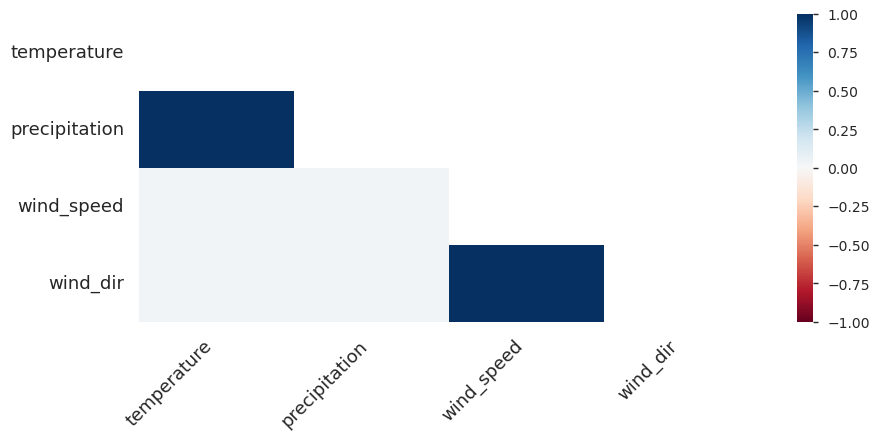

In [450]:
profile

Divide between features and target

In [431]:
X = data[['date', 
          'municipality.name', 
          'hour_category', 
          'temperature', 
          'minTemperature', 
          'maxTemperature', 
          'precipitation',
          'wind_speed',
          'wind_dir',
          'curr_cell',
          'curr_site',
          'tweet_count' 
]]
y = data['class']  # Target is the multi-class label (High, Medium, Low)

In [432]:
y

0          Low
1       Medium
2       Medium
3       Medium
4       Medium
         ...  
4867       Low
4868       Low
4869       Low
4870       Low
4871    Medium
Name: class, Length: 4872, dtype: object

## Random forest let's go

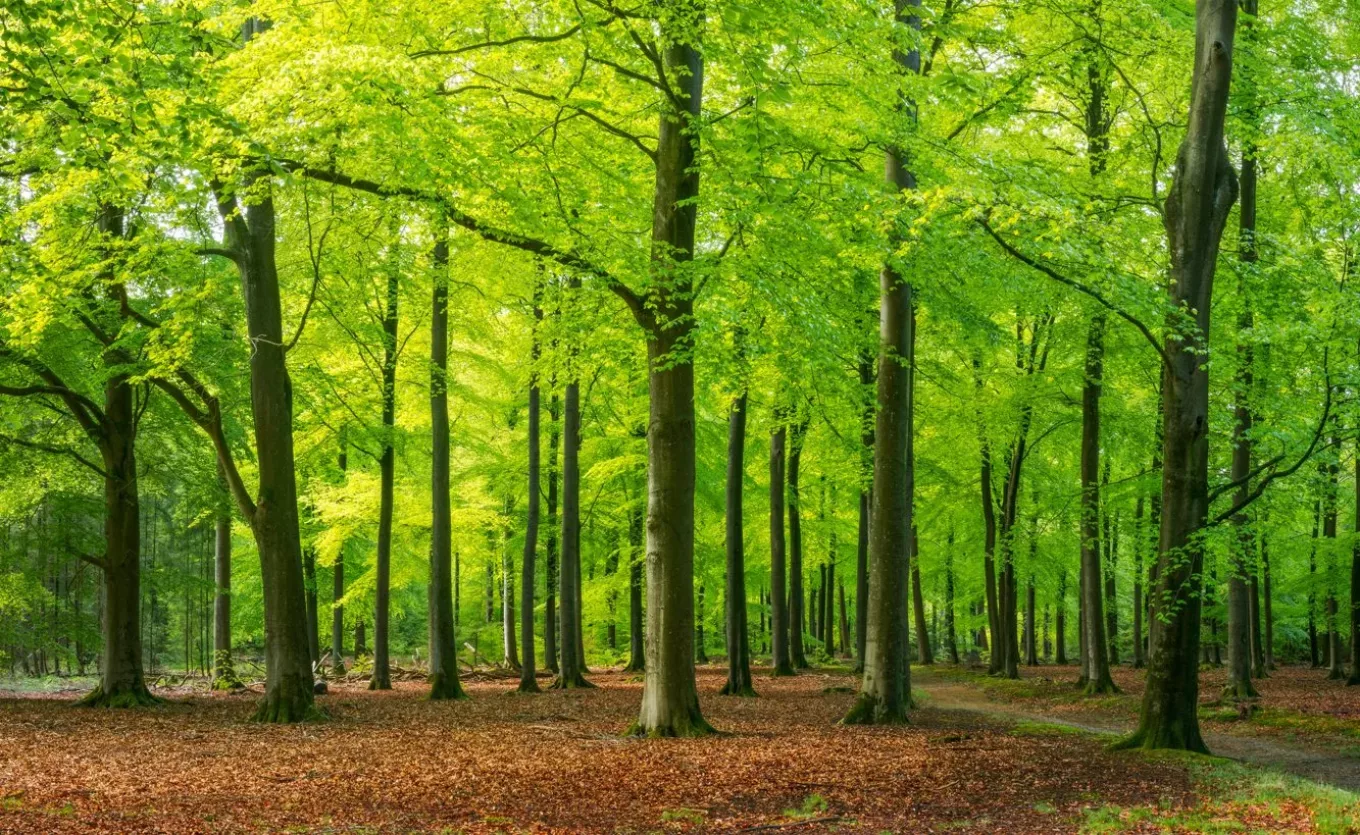

In [433]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [434]:
# Separate categorical features
categorical_features = ['date', 'municipality.name', 'hour_category']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'tweet_count', 
                      'wind_speed',
                      'wind_dir',
                      'curr_cell',
                      'curr_site']

In [435]:
# Encode categorical features
le = LabelEncoder()
for feat in categorical_features:
    X[feat] = le.fit_transform(X[feat])

/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_28418/717494479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = le.fit_transform(X[feat])
/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_28418/717494479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = le.fit_transform(X[feat])
/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_28418/717494479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [436]:
X[categorical_features]

date  municipality.name  hour_category
0        0                  4              0
1        0                  6              1
2        0                  6              2
3        0                  6              3
4        0                  7              1
...    ...                ...            ...
4867    59                155              1
4868    59                155              2
4869    59                156              3
4870    59                157              2
4871    59                157              3

[4872 rows x 3 columns]

In [437]:
# Scale the numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_features])

In [438]:
# Convert the scaled numerical features back to a DataFrame
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

In [439]:
# Combine the scaled numerical features and encoded categorical features
X = pd.concat([scaled_numerical_df, X[categorical_features].astype('category')], axis=1)

In [440]:
X.dtypes
# it is possible to separate month and day from date

temperature           float64
minTemperature        float64
maxTemperature        float64
precipitation         float64
tweet_count           float64
wind_speed            float64
wind_dir              float64
curr_cell             float64
curr_site             float64
date                 category
municipality.name    category
hour_category        category
dtype: object

In [441]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [442]:
y_test

1335       Low
1101       Low
4215       Low
2764       Low
1338    Medium
         ...  
4860      High
4278       Low
680     Medium
829     Medium
1543       Low
Name: class, Length: 975, dtype: object

In [443]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [444]:
# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [445]:
# Predict on test data
y_pred = rf_classifier.predict(X_test)

In [446]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9866666666666667
              precision    recall  f1-score   support

        High       1.00      0.67      0.80        39
         Low       1.00      1.00      1.00       436
      Medium       0.97      1.00      0.99       500

    accuracy                           0.99       975
   macro avg       0.99      0.89      0.93       975
weighted avg       0.99      0.99      0.99       975



In [447]:
confusion_matrix(y_test, y_pred)

array([[ 26,   0,  13],
       [  0, 436,   0],
       [  0,   0, 500]])

[Text(0, 0.5, 'high'), Text(0, 1.5, 'low'), Text(0, 2.5, 'medium')]

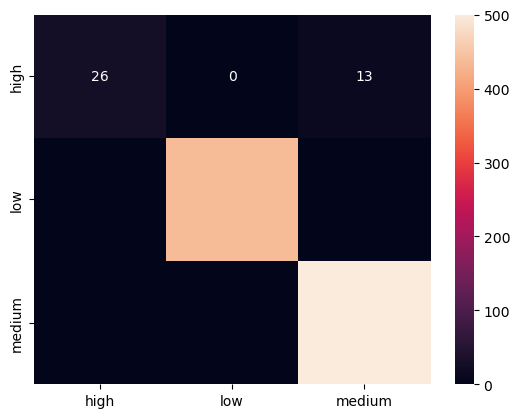

In [448]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax)
ax.xaxis.set_ticklabels(['high', 'low', 'medium'])
ax.yaxis.set_ticklabels(['high', 'low', 'medium'])

In [155]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

ValueError: multiclass format is not supported